![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

# Advanced Futures Trading Strategies

"Advanced Futures Trading Strategies" by Robert Carver lays the foundation for building a systematic trading system.

Although the book focuses on futures trading, its concepts are foundational and applicable to other financial instruments.

This notebook replicates the book's initial strategies, emphasizing data processing, metric building, and position size management with risk targeting.

# Data aquisition

In [1]:
from datetime import datetime
from QuantConnect import Resolution
from QuantConnect.Securities import Futures
from QuantConnect.Data.UniverseSelection import *
from helper import calculate_and_merge_returns, summarize_statistics, calculate_contract_risk, simulate_buy_and_hold, calculate_rolling_costs, calculate_combined_std
import numpy as np
from scipy.stats import skew

In [2]:
# Initialize QuantBook
qb = QuantBook()

# Updated Instruments Dictionary
instruments = {
    'ES': { # S&P 500
        'multiplier': 50,
        'tick_value': 0.25,
        'minimum_fluctuation': 12.50,
        'spread': 0.25, # diferencia entre bid y ask
        'commission': 2.50,
        'rolling_months': [3, 6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Indices.SP500EMini,
        'resolution': Resolution.Daily,
        'multiply_close': False # Ajuste manual que tengo que hacer para algunos instrumentos
    },
    'MES': {
        'multiplier': 5,
        'tick_value': 0.25,
        'minimum_fluctuation': 1.25,
        'spread': 0.25,
        'commission': 2.50,
        'rolling_months': [3, 6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Indices.MicroSP500EMini,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'ZN': {     # 10-Year Treasury
        'multiplier': 1000,
        'tick_value': 0.015625,
        'minimum_fluctuation': 15.625,
        'spread': 0.015625,
        'commission': 2.50,
        'rolling_months': [6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Financials.Y10TreasuryNote,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'ZF': {  # 5-Year Treasury
        'multiplier': 1000,
        'tick_value': 0.0078125,
        'minimum_fluctuation': 7.8125,
        'spread': 0.0078125,
        'commission': 2.50,
        'rolling_months': [3, 6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Financials.Y5TreasuryNote,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'ZB': {  # 30-Year Treasury
        'multiplier': 1000,
        'tick_value': 0.03125,
        'minimum_fluctuation': 31.25,
        'spread': 0.03125,
        'commission': 2.50,
        'rolling_months': [3, 6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Financials.Y30TreasuryBond,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'ZW': {  # Wheat
        'multiplier': 50,
        'tick_value': 0.25,
        'minimum_fluctuation': 12.50,
        'spread': 0.25,
        'commission': 2.50,
        'rolling_months': [3, 5, 7, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Grains.SRWWheat,
        'resolution': Resolution.Daily,
        'multiply_close': True
    },
    'CL': {  # Crude Oil
        'multiplier': 1000,
        'tick_value': 0.01,
        'minimum_fluctuation': 10.00,
        'spread': 0.01,
        'commission': 2.50,
        'rolling_months': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Energies.CrudeOilWTI,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'GC': {  # Gold
        'multiplier': 100,
        'tick_value': 0.1,
        'minimum_fluctuation': 10.00,
        'spread': 0.1,
        'commission': 2.50,
        'rolling_months': [2, 4, 6, 8, 10, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Metals.Gold,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'HE': {  # Lean Hog
        'multiplier': 400,
        'tick_value': 0.00025,
        'minimum_fluctuation': 10.00,
        'spread': 0.025,
        'commission': 2.50,
        'rolling_months': [2, 4, 6, 7, 8, 10, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Meats.LeanHogs,
        'resolution': Resolution.Daily,
        'multiply_close': True
    },
    'GF': {  # Feeder Cattle
        'multiplier': 500,
        'tick_value': 0.00025,
        'minimum_fluctuation': 12.50,
        'spread': 0.00025,
        'commission': 2.50,
        'rolling_months': [1, 3, 4, 5, 8, 9, 10, 11],
        'subscription_type': 'Future',
        'subscription_details': Futures.Meats.FeederCattle,
        'resolution': Resolution.Daily,
        'multiply_close': True
    },
    'ZS': {  # Soy Bean
        'multiplier': 50,
        'tick_value': 0.0025,
        'minimum_fluctuation': 12.50,
        'spread': 0.0025,
        'commission': 2.50,
        'rolling_months': [1, 3, 5, 7, 8, 9, 11],
        'subscription_type': 'Future',
        'subscription_details': Futures.Grains.Soybeans,
        'resolution': Resolution.Daily,
        'multiply_close': True
    },
    'ZC': {  # Corn
        'multiplier': 50,
        'tick_value': 0.0025,
        'minimum_fluctuation': 12.50,
        'spread': 0.0025,
        'commission': 2.50,
        'rolling_months': [3, 5, 7, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Grains.Corn,
        'resolution': Resolution.Daily,
        'multiply_close': True
    },
    'NG': {  # Natural Gas
        'multiplier': 10000,
        'tick_value': 0.001,
        'minimum_fluctuation': 10.00,
        'spread': 0.001,
        'commission': 2.50,
        'rolling_months': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Energies.NaturalGas,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'SI': {  # Silver
        'multiplier': 5000,
        'tick_value': 0.005,
        'minimum_fluctuation': 25.00,
        'spread': 0.005,
        'commission': 2.50,
        'rolling_months': [3, 5, 7, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Metals.Silver,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'HG': {  # Copper
        'multiplier': 25000,
        'tick_value': 0.0005,
        'minimum_fluctuation': 12.50,
        'spread': 0.0005,
        'commission': 2.50,
        'rolling_months': [3, 5, 7, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Metals.Copper,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'NQ': {  # Nasdaq
        'multiplier': 20,
        'tick_value': 0.25,
        'minimum_fluctuation': 5.00,
        'spread': 0.25,
        'commission': 2.50,
        'rolling_months': [3, 6, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Indices.NASDAQ100EMini,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'MGC': { # Micro gold
        'multiplier': 10,
        'tick_value': 0.1,
        'minimum_fluctuation': 1.00,
        'spread': 0.1,
        'commission': 2.50,
        'rolling_months': [2, 4, 6, 8, 10, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Metals.MicroGold,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'SIL': { # Micro silver
        'multiplier': 1000,
        'tick_value': 0.005,
        'minimum_fluctuation': 5.00,
        'spread': 0.005,
        'commission': 2.50,
        'rolling_months': [3, 5, 7, 9, 12],
        'subscription_type': 'Future',
        'subscription_details': Futures.Metals.MicroSilver,
        'resolution': Resolution.Daily,
        'multiply_close': False
    },
    'USDMXN': { #forex exchange rate to mxn
        'subscription_type': 'Forex',
        'subscription_details': 'USDMXN',
        'resolution': Resolution.Daily,
        'multiplier': 1,
        'multiply_close': False
    }
}


In [3]:
from datetime import datetime

# Add Subscriptions for Futures and Forex
subscriptions = {}
for symbol, details in instruments.items():
    if details['subscription_type'] == 'Future':
        future = qb.AddFuture(details['subscription_details'], details['resolution'])
        subscriptions[symbol] = future.Symbol
    elif details['subscription_type'] == 'Forex':
        forex = qb.AddForex(details['subscription_details'], details['resolution'])
        subscriptions[symbol] = forex.Symbol

# Set Historical Data Range
general_start_date = datetime(2007, 1, 1)
specific_start_date = datetime(2013, 1, 1)  # Fecha específica para SI
end_date = datetime.now()
trading_days_per_year = 256
capital = 100000
target_risk = .20

# Request Historical Data
timeseries = {}
for symbol, sub_symbol in subscriptions.items():
    start_date = specific_start_date if symbol == 'SI' else general_start_date
    history = qb.History([sub_symbol], start_date, end_date, instruments[symbol]['resolution'])
    if 'close' in history.columns and 'volume' in history.columns:
        if instruments[symbol]['subscription_type'] == 'Future':
            history.reset_index(level=0, drop=True, inplace=True)
        if instruments[symbol]['multiply_close']:
            history['close'] *= 100
        timeseries[symbol] = history[['close', 'volume']]
    else:
        print(f"No 'close' or 'volume' column found for {symbol}")

# Clean up
del details
del end_date
del future
del forex
del history
del general_start_date
del specific_start_date
del sub_symbol
del symbol



No 'close' or 'volume' column found for USDMXN


In [4]:

# Subscribe to USDMXN forex pair
usdmxn = qb.AddForex("USDMXN", Resolution.Daily).Symbol

# Retrieve historical data
history = qb.History([usdmxn], 365, Resolution.Daily)

# Ensure the 'close' data is correctly extracted from the history DataFrame
fx_data = history.loc[usdmxn][['close']]

del history
del usdmxn

## Print the timeseries

In [5]:
#Print symbols and first 5 entires of historical_data
for symbol, data in timeseries.items():
    print(symbol)
    print(data.tail())


ES
                              close     volume
symbol time                                   
ES 1S1 2024-06-25 20:00:00  5535.00   901562.0
       2024-06-26 20:00:00  5533.50   928999.0
       2024-06-27 20:00:00  5549.50  1016008.0
       2024-06-28 20:00:00  5532.25  1497621.0
       2024-07-01 20:00:00  5532.25        0.0
MES
                               close    volume
symbol  time                                  
MES 1S1 2024-06-25 20:00:00  5535.50  580670.0
        2024-06-26 20:00:00  5533.75  571185.0
        2024-06-27 20:00:00  5549.25  671100.0
        2024-06-28 20:00:00  5533.00  886223.0
        2024-07-01 20:00:00  5533.00       0.0
ZN
                                 close     volume
symbol time                                      
ZN MD  2024-06-25 19:00:00  110.500000   790931.0
       2024-06-26 19:00:00  110.000000  1056729.0
       2024-06-27 19:00:00  110.265625   957328.0
       2024-06-28 19:00:00  109.640625  2182679.0
       2024-07-01 19:00:00  109.

In [6]:
# Print timeseries' index
print(timeseries['ES'].index)

# Print timeseries' column names
print(timeseries['ES'].columns)


MultiIndex([('ES 1S1', '2007-01-03 19:00:00'),
            ('ES 1S1', '2007-01-04 19:00:00'),
            ('ES 1S1', '2007-01-05 19:00:00'),
            ('ES 1S1', '2007-01-08 19:00:00'),
            ('ES 1S1', '2007-01-09 19:00:00'),
            ('ES 1S1', '2007-01-10 19:00:00'),
            ('ES 1S1', '2007-01-11 19:00:00'),
            ('ES 1S1', '2007-01-12 19:00:00'),
            ('ES 1S1', '2007-01-16 19:00:00'),
            ('ES 1S1', '2007-01-17 19:00:00'),
            ...
            ('ES 1S1', '2024-06-18 20:00:00'),
            ('ES 1S1', '2024-06-19 20:00:00'),
            ('ES 1S1', '2024-06-20 20:00:00'),
            ('ES 1S1', '2024-06-21 20:00:00'),
            ('ES 1S1', '2024-06-24 20:00:00'),
            ('ES 1S1', '2024-06-25 20:00:00'),
            ('ES 1S1', '2024-06-26 20:00:00'),
            ('ES 1S1', '2024-06-27 20:00:00'),
            ('ES 1S1', '2024-06-28 20:00:00'),
            ('ES 1S1', '2024-07-01 20:00:00')],
           names=['symbol', 'time'], length

## Individual dataframe creation

In [37]:

for symbol, data in timeseries.items():
    globals()[symbol] = pd.DataFrame(data)

## Summary statistics
We can begin working with the aquired data to calculate some useful statistics, such as returns, standard deviations, skew and fat tail ratios. Use the helper function to process these statistics.

### Returns Time Series

In [7]:
# Creación de returns series

for symbol, price_df in timeseries.items():
    price_series = price_df['close']
    volume_series = price_df['volume']
    merged_df = calculate_and_merge_returns(symbol, price_series, volume_series, instruments)
    timeseries[symbol] = merged_df.loc[:, ['close', 'volume', 'price_return', 'currency_return', 'percentage_return']]

del price_df, price_series, volume_series, merged_df



### Summary Stats for each symbol
mean_return, std_dev, annualized_mean, annualized_std_dev, daily_sharpe_ratio, annualized_sharpe_ratio

In [8]:
summary = summarize_statistics(timeseries, trading_days_per_year)


In [9]:
print("Summary Statistics for Each Symbol:")

for symbol, stats in summary.items():
    print(f"{symbol}:")
    print(summary[symbol])


Summary Statistics for Each Symbol:
ES:
{'mean_return': 0.03838245354956212, 'std_dev': 1.247289347880321, 'annualized_mean': 10.32277803496604, 'annualized_std_dev': 19.956629566085137, 'daily_sharpe_ratio': 0.030772694094429936, 'annualized_sharpe_ratio': 0.492363105510879, 'monthly_skew': -14.420997661545941, 'lower_fat_tail_ratio': 2.56821424379646, 'higher_fat_tail_ratio': 1.7477974295417311}
MES:
{'mean_return': 0.052357069260961245, 'std_dev': 1.290466769391294, 'annualized_mean': 14.339170070738483, 'annualized_std_dev': 20.647468310260702, 'daily_sharpe_ratio': 0.04057219488546597, 'annualized_sharpe_ratio': 0.6491551181674555, 'monthly_skew': -7.747007747011125, 'lower_fat_tail_ratio': 2.1418304146158795, 'higher_fat_tail_ratio': 1.42861266562991}
ZN:
{'mean_return': 0.008252261581743798, 'std_dev': 0.38458812774159307, 'annualized_mean': 2.134962864185841, 'annualized_std_dev': 6.153410043865489, 'daily_sharpe_ratio': 0.021457400752860834, 'annualized_sharpe_ratio': 0.343318

## Backtest buy and hold 1 contract.

In [10]:
 # Rolling costs per instrument. uncomment to compute

 rolling_costs_per_instrument = {}

 for symbol, data in timeseries.items():
     instrument_details = instruments[symbol]
     rolling_costs = calculate_rolling_costs(instrument_details, data)
     rolling_costs_per_instrument[symbol] = rolling_costs

 print(rolling_costs_per_instrument)


{'ES': 1225.0, 'MES': 131.25, 'ZN': 1072.5, 'ZF': 896.875, 'ZB': 2537.5, 'ZW': 1540.0, 'CL': 3165.0, 'GC': 1050.0, 'HE': 1845.0, 'GF': 717.5, 'ZS': 630.375, 'ZC': 451.0, 'NG': 3165.0, 'SI': 1740.0, 'HG': 1172.5, 'NQ': 700.0, 'MGC': 498.0, 'SIL': 560.0}


In [11]:
# Your existing simulation code
buyhold_results = {}

for symbol, data in timeseries.items():
    print(f"Symbol: {symbol}, Start Date: {data.index[0][1]}, End Date: {data.index[-1][1]}")
    instrument_details = instruments[symbol]
        
    num_contracts = 1  # Specify the number of contracts as needed
    
    bnh_return, bnh_return_mxn = simulate_buy_and_hold(data, instrument_details, fx_data, num_contracts)
    buyhold_results[symbol] = {
        'bnh_return': bnh_return,
        'bnh_return_mxn': bnh_return_mxn
    }
print(buyhold_results)

Symbol: ES, Start Date: 2007-01-04 19:00:00, End Date: 2024-07-01 20:00:00
Symbol: MES, Start Date: 2019-05-07 20:00:00, End Date: 2024-07-01 20:00:00
Symbol: ZN, Start Date: 2007-01-04 18:00:00, End Date: 2024-07-01 19:00:00
Symbol: ZF, Start Date: 2007-01-04 18:00:00, End Date: 2024-07-01 19:00:00
Symbol: ZB, Start Date: 2007-01-04 18:00:00, End Date: 2024-07-01 19:00:00
Symbol: ZW, Start Date: 2007-01-04 18:00:00, End Date: 2024-07-01 19:00:00
Symbol: CL, Start Date: 2007-01-04 19:00:00, End Date: 2024-07-01 20:00:00
Symbol: GC, Start Date: 2012-11-01 20:00:00, End Date: 2024-07-01 20:00:00
Symbol: HE, Start Date: 2007-01-04 18:00:00, End Date: 2024-07-01 19:00:00
Symbol: GF, Start Date: 2007-01-09 18:00:00, End Date: 2024-07-01 19:00:00
Symbol: ZS, Start Date: 2007-01-04 18:00:00, End Date: 2024-07-01 19:00:00
Symbol: ZC, Start Date: 2007-01-04 18:00:00, End Date: 2024-07-01 19:00:00
Symbol: NG, Start Date: 2007-01-04 19:00:00, End Date: 2024-07-01 20:00:00
Symbol: SI, Start Date: 

# Strategy 2: Risk measurement, risk target and capital


## Contract risk in base currency

Update summary dictionary to include the daily and annual contract risk 

risk in currency terms = notional exposure * std dev

notional exposure = last closing price * multiplier

compute number of instruments to achieve target risk given a static risk 

In [12]:
# Update summary with contract risks

summary = calculate_contract_risk(summary, instruments, timeseries)
print("Summary Statistics for Each Symbol with Contract Risks:")
for symbol, stats in summary.items():
    print(f"{symbol}:")
    print(summary[symbol])

Summary Statistics for Each Symbol with Contract Risks:
ES:
{'mean_return': 0.03838245354956212, 'std_dev': 1.247289347880321, 'annualized_mean': 10.32277803496604, 'annualized_std_dev': 19.956629566085137, 'daily_sharpe_ratio': 0.030772694094429936, 'annualized_sharpe_ratio': 0.492363105510879, 'monthly_skew': -14.420997661545941, 'lower_fat_tail_ratio': 2.56821424379646, 'higher_fat_tail_ratio': 1.7477974295417311, 'daily_contract_risk': 3450.158247405453, 'annualized_contract_risk': 55202.53195848725}
MES:
{'mean_return': 0.052357069260961245, 'std_dev': 1.290466769391294, 'annualized_mean': 14.339170070738483, 'annualized_std_dev': 20.647468310260702, 'daily_sharpe_ratio': 0.04057219488546597, 'annualized_sharpe_ratio': 0.6491551181674555, 'monthly_skew': -7.747007747011125, 'lower_fat_tail_ratio': 2.1418304146158795, 'higher_fat_tail_ratio': 1.42861266562991, 'daily_contract_risk': 357.0076317521015, 'annualized_contract_risk': 5712.122108033624}
ZN:
{'mean_return': 0.008252261581

In [13]:
# Compute target risk in currency
target_risk_in_usd = capital * target_risk

# Compute position size
def calculate_position_size(target_risk_in_usd, contract_risk, capital):
    return target_risk_in_usd / contract_risk

In [14]:
# Calculate position size for each symbol
position_sizes = {}
for symbol, stats in summary.items():
    position_size = calculate_position_size(target_risk_in_usd, stats['annualized_contract_risk'], capital)
    position_sizes[symbol] = position_size
# Print position sizes
print ("Position sizes to achieve target risk per instrument:")
for symbol, position_size in position_sizes.items():
    print(f"{symbol}: {position_size}")


Position sizes to achieve target risk per instrument:
ES: 0.36230222220676694
MES: 3.5013257107847306
ZN: 2.964439811344586
ZF: 1.2814629666534911
ZB: 1.5407371054149934
ZW: 2.1065034583914906
CL: 0.6034036080535997
GC: 0.5596528901348549
HE: 1.994280831085987
GF: 0.9189193274324228
ZS: 1.5014936263064689
ZC: 3.3949935484516898
NG: 1.599753763765341
SI: 0.49100638982083544
HG: 0.8153354784106054
NQ: 0.22334544598376466
MGC: 1.3559854534188023
SIL: 0.862196524283841


# Strategy 3, rolling windows and combined long and short term risk metric

In [15]:
# Calcular la desviación estándar combinada y agregarla a timeseries
returns_std = calculate_combined_std(timeseries)
for symbol, std_series in returns_std.items():
    timeseries[symbol]['combined_std'] = std_series


### El tamaño de la posición se calcula correctamente, continuamos con la implementación del backtest

## Strat 3 backtest

Strat 3 backtest 01/07/2024

In [53]:
import pandas as pd
import numpy as np
from datetime import datetime
from collections import defaultdict

def strategy_3(timeseries, instruments, capital_initial, target_risk=0.20):
    """
    Implements a financial trading strategy based on risk-adjusted position sizing.
    
    :param timeseries: Dict of DataFrames containing time series data for each instrument
    :param instruments: Dict containing instrument-specific information (e.g., multiplier)
    :param capital_initial: Initial capital for the strategy
    :param target_risk: Target risk as a fraction of capital (default: 20%)
    :return: DataFrame of results, dict of average round trips, dict of position logs
    """
    results = []
    yearly_round_trips = defaultdict(lambda: defaultdict(int))
    position_logs = {symbol: [] for symbol in timeseries.keys()}
    contracts_opened = {symbol: 0 for symbol in timeseries.keys()}
    
    for symbol, data in timeseries.items():
        # Add day of week if not present
        if 'day_of_week' not in data.columns:
            data['day_of_week'] = data.index.get_level_values('time').map(lambda x: x.weekday())

        capital = capital_initial
        max_capital = capital
        prev_positions = 0
        last_friday_position = 0
        sample_count = 0
        multiplier = instruments[symbol]['multiplier']

        for idx, row in data.iterrows():
            current_year = idx[1].year
            sample_count += 1
            
            # Calculate target risk and position size
            target_risk_in_usd = capital * target_risk
            contract_risk_currency = row['combined_std'] * row['close'] * multiplier
            position_size_float = target_risk_in_usd / contract_risk_currency if contract_risk_currency > 0 else 0
            new_position = np.round(position_size_float)

            # Warm-up period: first 40 samples
            if sample_count <= 40:
                results.append({
                    'time': idx[1], 'symbol': symbol, 'position_size': 0, 'position_size_float': 0,
                    'capital': capital, 'drawdown': max_capital - capital,
                    'target_risk_in_usd': 0, 'combined_std': row['combined_std'],
                    'contract_risk_currency': contract_risk_currency,
                    'currency_return': row['currency_return'], 'close_price': row['close']
                })
                continue

            # Store Friday's position for Monday's trading
            if row['day_of_week'] == 4:  # Friday
                last_friday_position = new_position
            
            # Adjust positions on Monday based on Friday's calculation
            if row['day_of_week'] == 0 and last_friday_position is not None:  # Monday
                position_change = new_position - prev_positions
                if position_change > 0:
                    # Opened new contracts
                    contracts_opened[symbol] += position_change
                    position_logs[symbol].append(f"Opened {position_change} contracts on {idx[1]}: Total position {new_position}")
                elif position_change < 0:
                    # Closed contracts
                    closed_contracts = min(abs(position_change), contracts_opened[symbol])
                    yearly_round_trips[symbol][current_year] += closed_contracts
                    contracts_opened[symbol] -= closed_contracts
                    position_logs[symbol].append(f"Closed {closed_contracts} contracts on {idx[1]}: Total position {new_position}, Yearly round trips {yearly_round_trips[symbol][current_year]}")

                prev_positions = new_position

            # Calculate daily return and update capital
            daily_return = row['currency_return'] * prev_positions
            capital += daily_return
            max_capital = max(max_capital, capital)
            drawdown = max_capital - capital
            
            # Store results for this iteration
            results.append({
                'time': idx[1], 'symbol': symbol, 'position_size': prev_positions, 'position_size_float': position_size_float,
                'capital': capital, 'drawdown': drawdown,
                'target_risk_in_usd': target_risk_in_usd, 'combined_std': row['combined_std'],
                'contract_risk_currency': contract_risk_currency,
                'currency_return': row['currency_return'], 'close_price': row['close']
            })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate average round trips per year
    avg_round_trips = {}
    for symbol, yearly_trips in yearly_round_trips.items():
        total_trips = sum(yearly_trips.values())
        num_years = len(yearly_trips)
        avg_round_trips[symbol] = total_trips / num_years if num_years > 0 else 0

    return results_df, avg_round_trips, position_logs

# Define backtest parameters and execute
capital_initial = 100000
results, avg_round_trips, position_logs = strategy_3(timeseries, instruments, capital_initial)

# Print results
print("Global backtest results:")
print(results.tail())
print("\nAverage round trips per year:")
print(avg_round_trips)

# Print detailed logs for ES and MES
print("\nDetailed position logs for ES:")
print("\n".join(position_logs['ES'][:10]))  # Print first 10 log entries
print("\nDetailed position logs for MES:")
print("\n".join(position_logs['MES'][:10]))  # Print first 10 log entries

Global backtest results:
                     time symbol  position_size  position_size_float  \
69774 2024-06-25 20:00:00    SIL            0.0             0.099788   
69775 2024-06-26 20:00:00    SIL            0.0             0.098959   
69776 2024-06-27 20:00:00    SIL            0.0             0.098311   
69777 2024-06-28 20:00:00    SIL            0.0             0.098535   
69778 2024-07-01 20:00:00    SIL            0.0             0.099409   

           capital      drawdown  target_risk_in_usd  combined_std  \
69774  3712.167175  99471.448761          742.433435      0.257353   
69775  3712.167175  99471.448761          742.433435      0.260818   
69776  3712.167175  99471.448761          742.433435      0.260950   
69777  3712.167175  99471.448761          742.433435      0.259146   
69778  3712.167175  99471.448761          742.433435      0.256868   

       contract_risk_currency  currency_return  close_price  
69774             7440.088210           -690.0       28.910

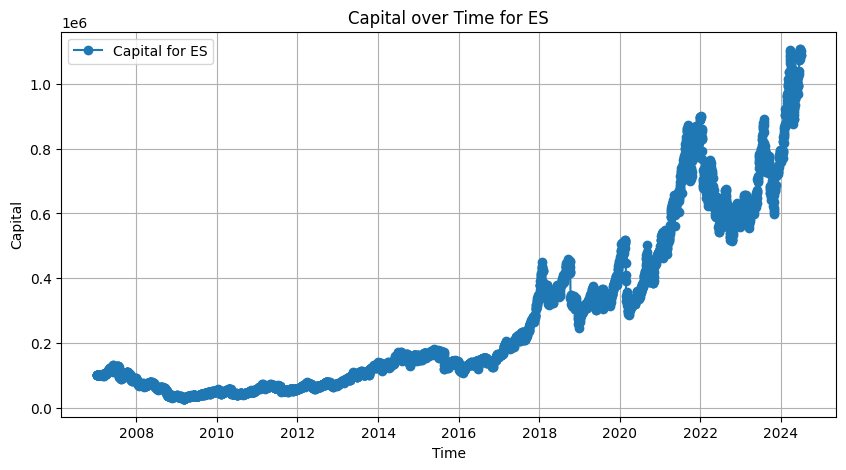

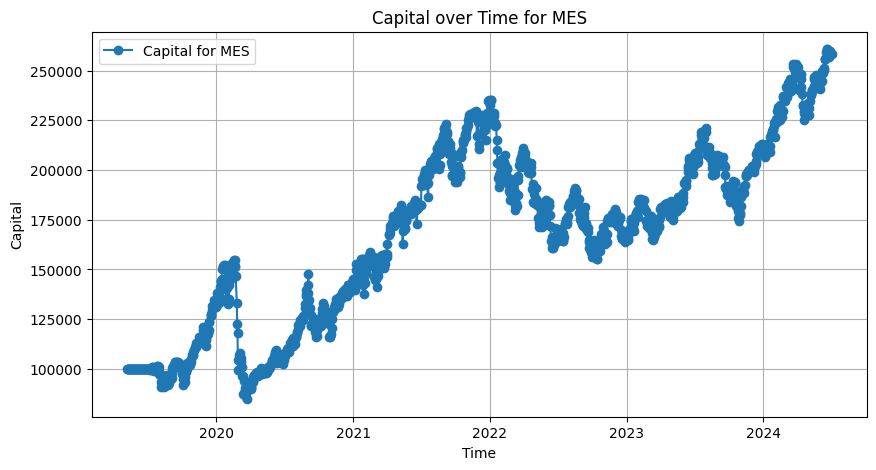

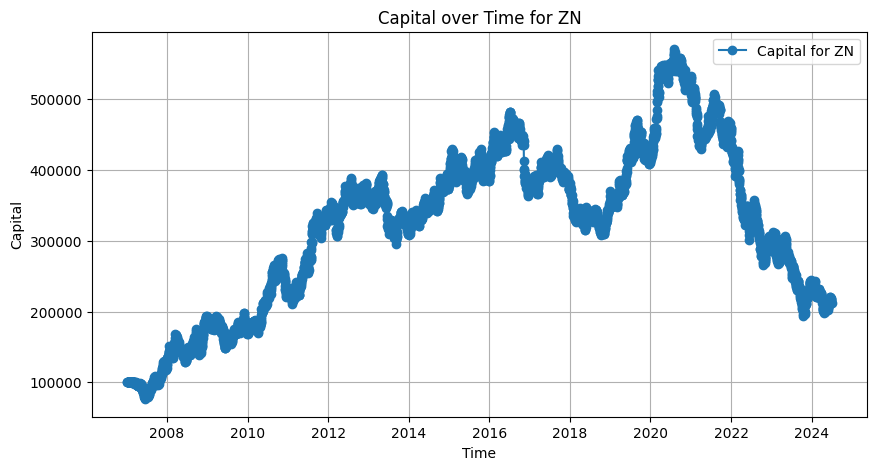

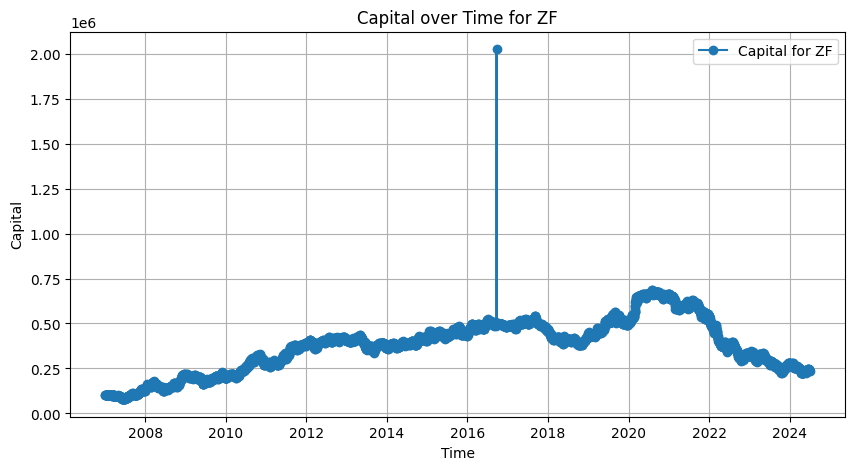

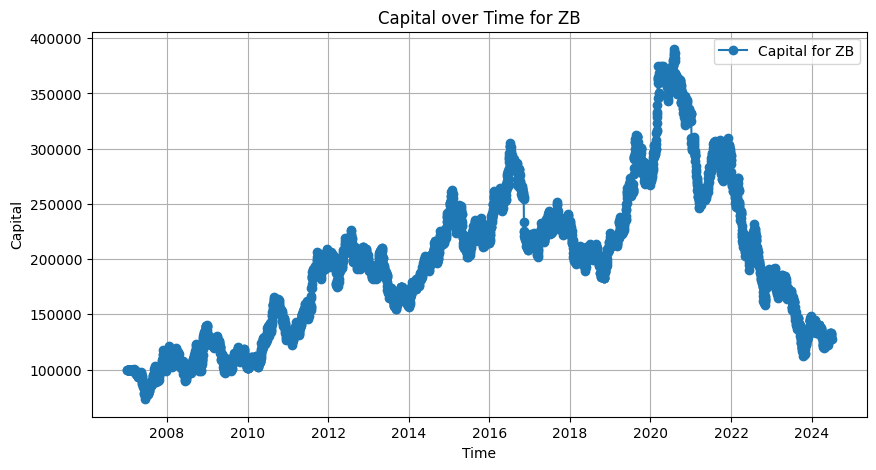

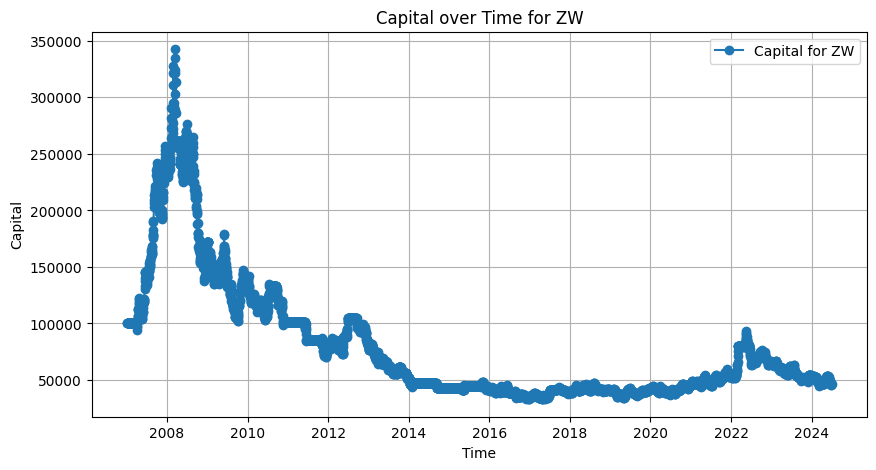

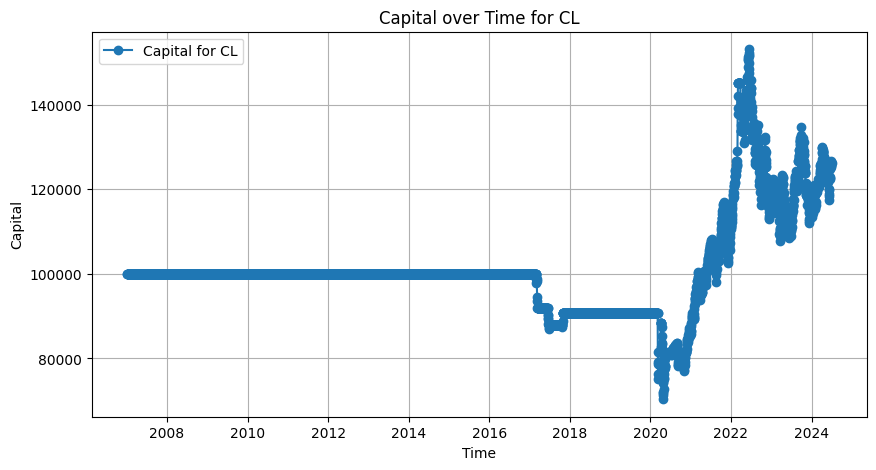

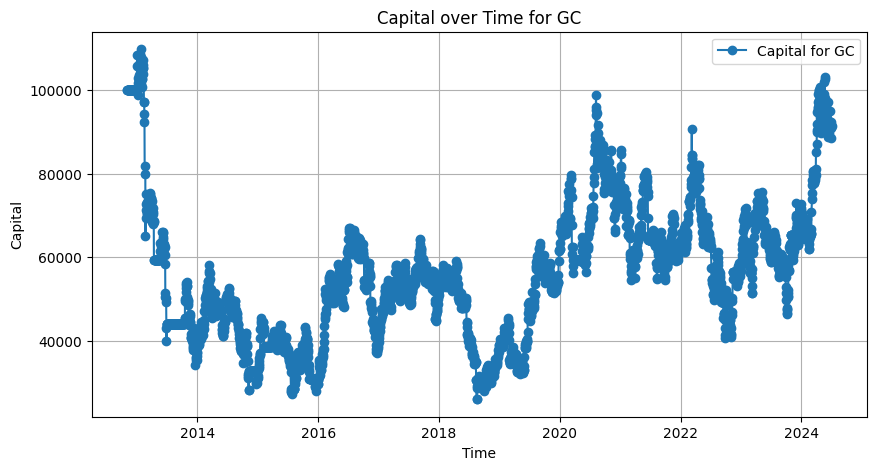

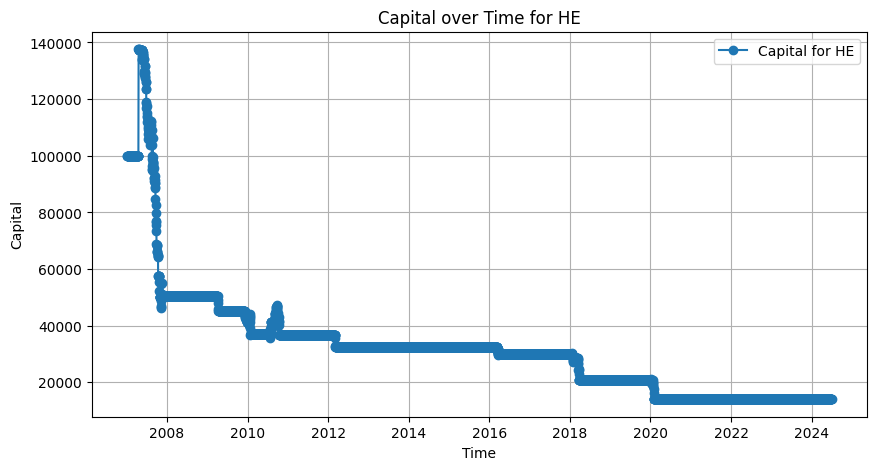

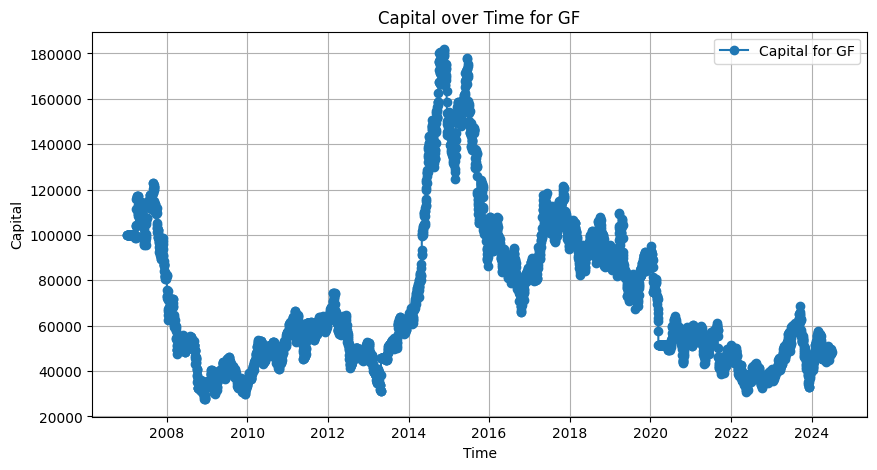

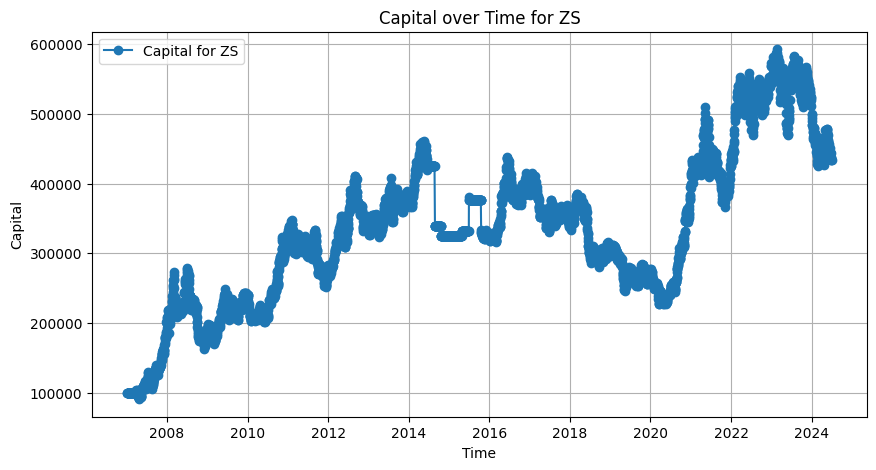

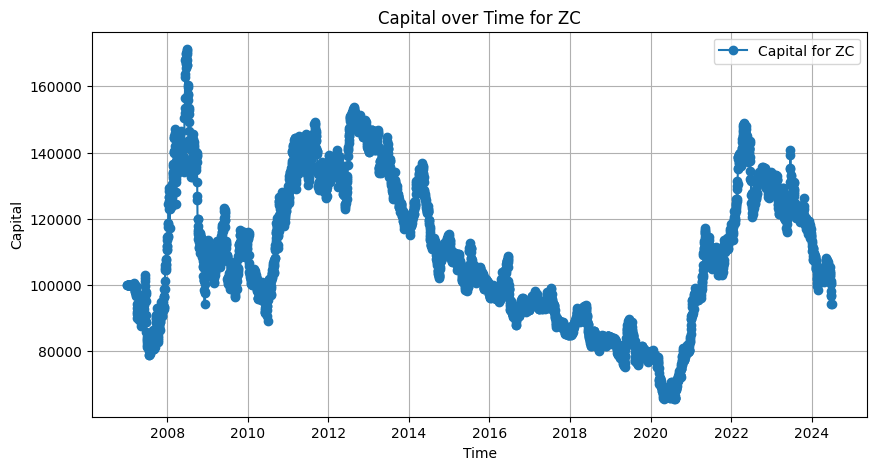

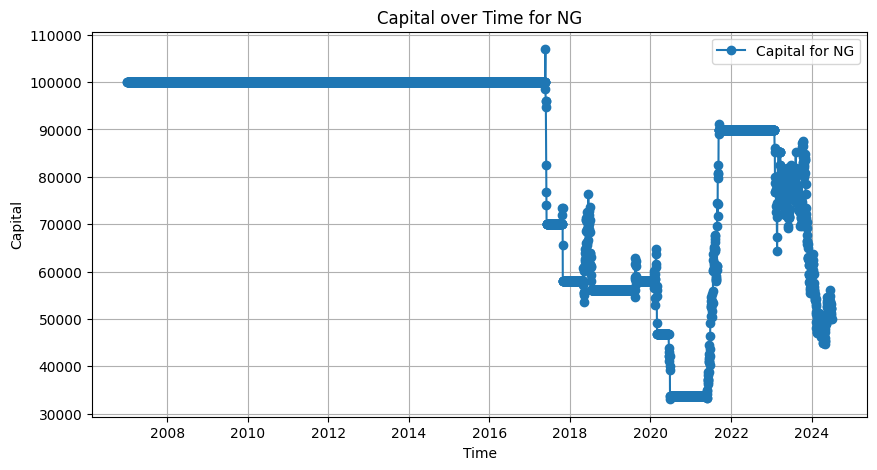

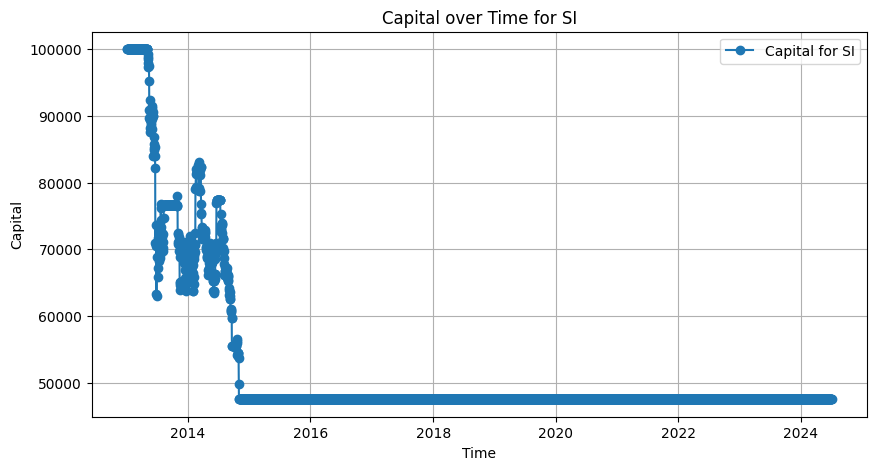

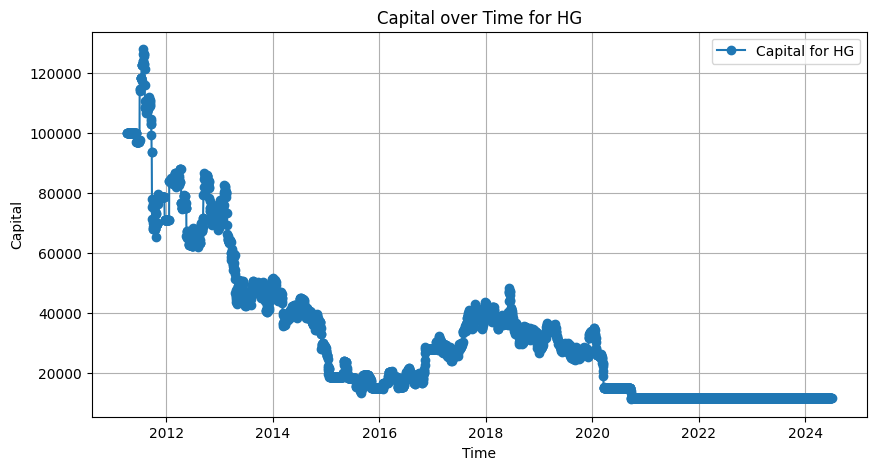

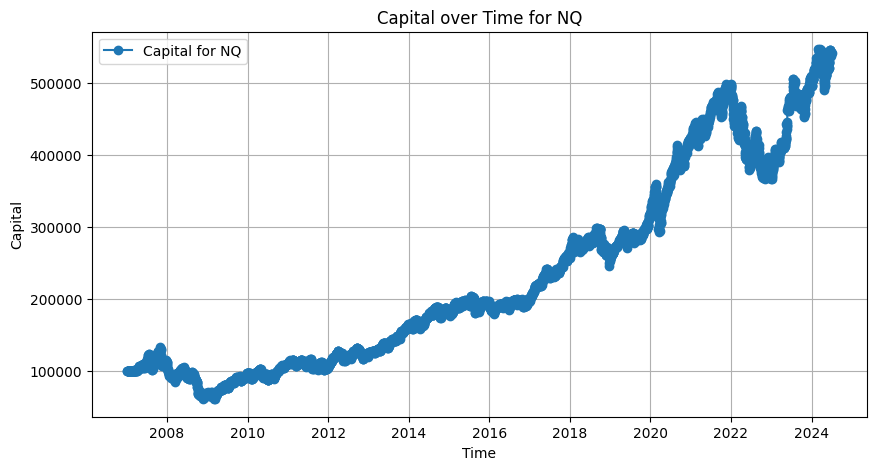

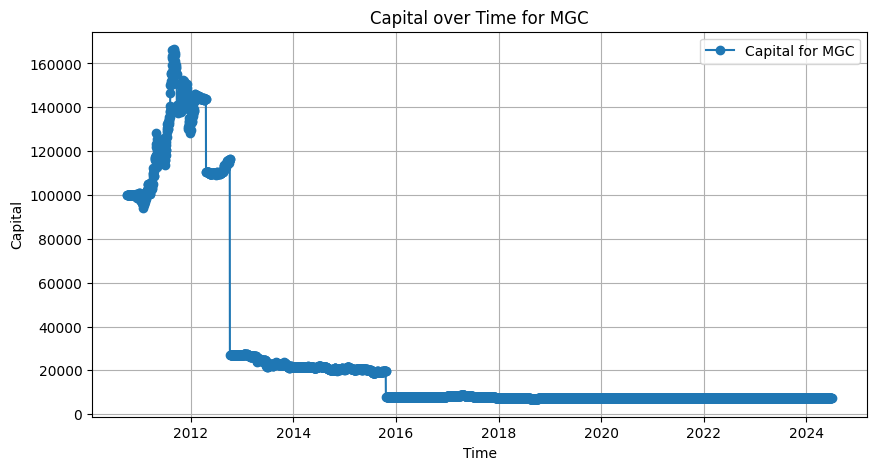

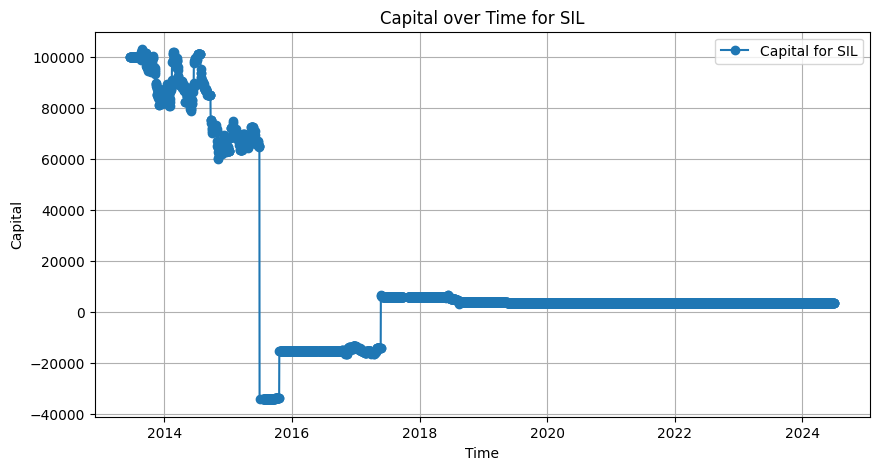

In [54]:
import matplotlib.pyplot as plt

def plot_capital_per_instrument_separately(results):
    symbols = results['symbol'].unique()
    for symbol in symbols:
        data = results[results['symbol'] == symbol]
        plt.figure(figsize=(10, 5))
        plt.plot(data['time'], data['capital'], label=f'Capital for {symbol}', marker='o', linestyle='-')
        plt.title(f'Capital over Time for {symbol}')
        plt.xlabel('Time')
        plt.ylabel('Capital')
        plt.grid(True)
        plt.legend()
        plt.show()

# Ejecutar la función de visualización
plot_capital_per_instrument_separately(results)


In [34]:
# Filtrar el DataFrame para el símbolo 'ES'
es_results = results[results['symbol'] == 'ES']

# Guardar el DataFrame filtrado a un archivo CSV
es_results.to_csv('ES_results.csv', index=False)

print("El archivo 'ES_results.csv' ha sido guardado exitosamente.")


El archivo 'ES_results.csv' ha sido guardado exitosamente.


## Strat 3 Risk adjusted cost and return

In [52]:
import numpy as np
import pandas as pd

def strat_3_performance_metrics(results, avg_round_trips, instruments, risk_free_rate=0, trading_days=252):
    performance_metrics = {}

    for symbol in results['symbol'].unique():
        symbol_data = results[results['symbol'] == symbol].copy()
        instrument = instruments[symbol]

        # Check if 'time' is in the index or as a column
        if 'time' in symbol_data.index.names:
            symbol_data['year'] = symbol_data.index.get_level_values('time').year
        elif 'time' in symbol_data.columns:
            symbol_data['year'] = pd.to_datetime(symbol_data['time']).dt.year
        else:
            raise ValueError("'time' information not found in results DataFrame")

        # Calculate daily returns
        daily_returns = symbol_data['capital'].pct_change().dropna()

        # Sharpe Ratio calculations
        annualized_return = (1 + daily_returns.mean()) ** trading_days - 1
        annualized_volatility = daily_returns.std() * np.sqrt(trading_days)
        sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility != 0 else np.nan

        # Risk-adjusted cost calculations
        spread_cost_currency = instrument['multiplier'] * (instrument['spread'] / 2)
        total_cost_per_trade = spread_cost_currency + instrument['commission']
        
        avg_close_price = symbol_data['close_price'].mean()
        total_cost_per_trade_pct = total_cost_per_trade / (avg_close_price * instrument['multiplier'])
        
        risk_adjusted_cost_per_trade = total_cost_per_trade_pct / annualized_volatility if annualized_volatility != 0 else np.inf
        
        rolls_per_year = len(instrument['rolling_months'])
        risk_adjusted_holding_cost = risk_adjusted_cost_per_trade * rolls_per_year * 2

        # Yearly position and turnover calculations
        yearly_metrics = symbol_data.groupby('year').agg({
            'position_size': 'mean',
            'capital': lambda x: x.pct_change().std() * np.sqrt(trading_days)  # Yearly volatility
        })
        yearly_metrics['turnover'] = yearly_metrics.index.map(lambda year: avg_round_trips[symbol] / yearly_metrics.loc[year, 'position_size'] if yearly_metrics.loc[year, 'position_size'] != 0 else 0)
        
        avg_position = yearly_metrics['position_size'].mean()
        avg_turnover = yearly_metrics['turnover'].mean()
        
        risk_adjusted_transaction_cost = avg_turnover * risk_adjusted_cost_per_trade
        
        annual_risk_adjusted_cost = risk_adjusted_holding_cost + risk_adjusted_transaction_cost

        # Post-cost Sharpe Ratio (directly adjusted)
        post_cost_sharpe_ratio = sharpe_ratio - annual_risk_adjusted_cost

        performance_metrics[symbol] = {
            'annualized_return': annualized_return,
            'annualized_volatility': annualized_volatility,
            'sharpe_ratio': sharpe_ratio,
            'spread_cost_currency': spread_cost_currency,
            'total_cost_per_trade': total_cost_per_trade,
            'total_cost_per_trade_pct': total_cost_per_trade_pct,
            'risk_adjusted_cost_per_trade': risk_adjusted_cost_per_trade,
            'risk_adjusted_holding_cost': risk_adjusted_holding_cost,
            'avg_position': avg_position,
            'avg_turnover': avg_turnover,
            'risk_adjusted_transaction_cost': risk_adjusted_transaction_cost,
            'annual_risk_adjusted_cost': annual_risk_adjusted_cost,
            'post_cost_sharpe_ratio': post_cost_sharpe_ratio
        }

    return pd.DataFrame(performance_metrics).T

# Usage example:
# Assuming 'results', 'avg_round_trips', and 'instruments' are available from previous calculations
strat_3_metrics_df = strat_3_performance_metrics(results, avg_round_trips, instruments)

# Display the results
print(strat_3_metrics_df)

# You can also access specific metrics for each symbol, e.g.:
for symbol in strat_3_metrics_df.index:
    print(f"\nPerformance metrics for {symbol}:")
    print(f"Sharpe Ratio: {strat_3_metrics_df.loc[symbol, 'sharpe_ratio']:.4f}")
    print(f"Annual Risk-Adjusted Cost: {strat_3_metrics_df.loc[symbol, 'annual_risk_adjusted_cost']:.4f}")
    print(f"Post-Cost Sharpe Ratio: {strat_3_metrics_df.loc[symbol, 'post_cost_sharpe_ratio']:.4f}")

# To use a specific risk-free rate:
# strat_3_metrics_df_with_rf = strat_3_performance_metrics(results, avg_round_trips, instruments, risk_free_rate=0.02)

     annualized_return  annualized_volatility  sharpe_ratio  \
ES            0.228545               0.377130      0.606011   
MES           0.253573               0.301803      0.840193   
ZN            0.069908               0.221324      0.315865   
ZF            0.229083               0.792689      0.288995   
ZB            0.045378               0.246522      0.184071   
ZW           -0.005346               0.278051     -0.019228   
CL            0.020472               0.116581      0.175606   
GC            0.098115               0.449155      0.218444   
HE           -0.094760               0.156552     -0.605294   
GF            0.027927               0.371772      0.075118   
ZS            0.117917               0.233711      0.504540   
ZC            0.014450               0.188495      0.076658   
NG           -0.021147               0.191058     -0.110685   
SI           -0.053360               0.140913     -0.378676   
HG           -0.087287               0.373249     -0.23